In [1]:
import momi
import os
os.chdir('..')
import logging
logging.basicConfig(level=logging.INFO,
                    filename="logs/4pops_sim.log")

In [2]:
model = momi.DemographicModel(N_e=1e4, gen_time=25, muts_per_gen=1.25e-8)

model.add_leaf("A")
model.add_leaf("B")
model.add_leaf("C")
model.add_leaf("D")

model.move_lineages("B", "C", t=5e3, p=.3)
model.move_lineages("A", "B", t=1e4)
model.move_lineages("B", "C", t=5e4)
model.move_lineages("C", "D", t=1e5)

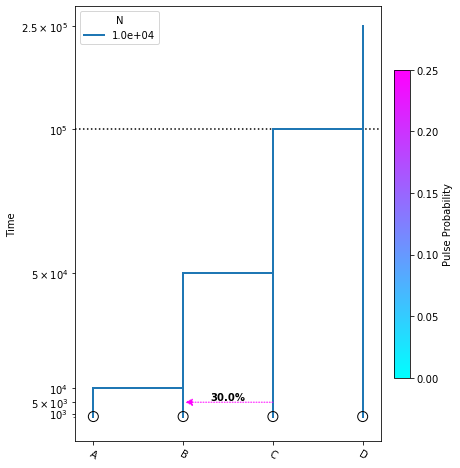

In [3]:
%matplotlib inline

yticks = [1e3, 5e3, 1e4, 5e4, 1e5, 2.5e5]

fig = momi.DemographyPlot(
    model, ["A", "B", "C", "D"],
    figsize=(6,8),
    major_yticks=yticks,
    linthreshy=1e5, pulse_color_bounds=(0,.25))

In [4]:
def generate_simulated_files(model, vcf_name, n_chrom):
    '''
    model (demo): model name
    n_chrom (int): total number of chromsome
    '''
    recoms_per_gen = 1.25e-8
    bases_per_locus = int(5e6)
    ploidy = 2        
    sampled_n_dict = {"A": 6,"B": 6, "C": 6, "D":6}

    for rep in range(1, n_chrom+1):
      model.simulate_vcf(
            f"data/{vcf_name}.rep{rep}",
            recoms_per_gen=recoms_per_gen,
            length=bases_per_locus,
            chrom_name=f"1",
            ploidy=ploidy,
            sampled_n_dict=sampled_n_dict,
            force=True)

In [5]:
models = [model]
vcfs = ['admixed_4pops']
n_chrom = [10]

for config in zip(models, vcfs, n_chrom):
    generate_simulated_files(config[0], config[1], config[2])

In [5]:
sampled_n_dict = {"A": 6,"B": 6, "C": 6, "D": 6}
ploidy = 2  

# a dict mapping samples to populations
ind2pop = {}
for pop, n in sampled_n_dict.items():
    for i in range(int(n / ploidy)):
        ind2pop["{}_{}".format(pop, i)] = pop

with open("data/4pops_ind2pop.txt", "w") as f:
    for i, p in ind2pop.items():
        print(i, p, sep="\t", file=f)

In [6]:
prefix = 'admixed_4pops.rep'
rep = '1'
# reading in sfs from data
bashCommand = "python -m momi.read_vcf data/{0}{1}.vcf.gz data/4pops_ind2pop.txt data/{0}{1}.snpAlleleCounts.gz --bed data/{0}{1}.bed".format(prefix, rep)
os.system(bashCommand)
bashCommand = "python -m momi.extract_sfs data/sfs_{0}{1}.gz 100 data/{0}{1}.snpAlleleCounts.gz".format(prefix, rep)
os.system(bashCommand)
sfs = momi.Sfs.load("data/sfs_{0}{1}.gz".format(prefix, rep))